In [ ]:
# imports

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from graphviz import Digraph
import random
from sklearn.metrics import RocCurveDisplay, roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
class LogitTree:
    
    def __init__(self, max_depth=5, min_leaf_samples=10, num_split_attributes=1):
        '''
            max_depth: Maximum depth of the decision tree
            min_leaf_samples: Minimum training samples at leaf nodes
            num_split_attributes: Number of attributes at each node in decision tree. Can only take values 1 or 2.
        '''
        self.max_depth = max_depth
        self.min_leaf_samples = min_leaf_samples
        self.num_split_attributes = num_split_attributes
        self.header = []
        assert num_split_attributes in range(1, 3), 'num_split_attributes can only take values 1 or 2.'
    
    
    def _log_regr(self, X, y):
        model = LogisticRegression(max_iter=10000)
        is_fitted = -1
        
        if len(list(set(y))) == 1:
            y_pred = np.ones((len(X),), dtype=int) * y[0]
            is_fitted = y[0]
        else:
            model.fit(X, y)
            y_pred = model.predict(X)
            
        loss = mean_squared_error(y, y_pred)
        return loss, model, is_fitted
    
        
    def _create_node(self, X, y, depth):
        loss, model, is_fitted = self._log_regr(X, y)
        return { 
                'X': X, 
                'len(X)': len(X),
                'y': y, 
                'len(y)': len(y),
                'depth': depth,
                'loss': loss,
                'model': model,
                'is_fitted': is_fitted,
                'attribute': None, 
                'threshold': None, 
                'left_child': None,
                'right_child': None}
    
    
    def _split_data(self, attr, threshold, X, y):
        if self.num_split_attributes == 1:
            left = (X[:, attr] <= threshold)
        else:
            left = (X[:, attr[0]] <= threshold[0]) & (X[:, attr[1]] <= threshold[1])   
        
        right = np.delete(np.arange(0, len(X)), left)
        left = np.delete(np.arange(0, len(X)), right)
        
        assert len(X) == len(left) + len(right)
        return (X[left], y[left]), (X[right], y[right])
    
    
    def _is_split(self, node):
        n, cols = node['X'].shape
        is_split = False
        min_loss = node['loss']
        X = node['X']
        y = node['y']
        
        data = [(X, y)]
        
        attribute = []
        threshold = []
        model = [node['model']]
        
        
        if node['depth'] >= self.max_depth:
            return {
                'is_split': is_split,
                'loss': min_loss,
                'data': data,
                'attribute': attribute,
                'threshold': threshold,
                'model': model
            }
        
        search_threshold = []
        search_attr = []
        
        if self.num_split_attributes == 1:
            for attr in range(cols):
                values = np.array(list(set(X[:, attr])))
                
                if len(values) > 100:
                    values = np.linspace(np.min(values), np.max(values), 100, endpoint=True)
                    
                search_threshold.append(values)
                search_attr.append(attr)  

        # two attribues     
        else:
            for attr1 in range(cols):
                for attr2 in range(attr1 + 1, cols):
                    
                    values1 = np.array(list(set(X[:, attr1])))
                    values2 = np.array(list(set(X[:, attr2])))
                    
                    if len(values1) > 100:
                        values1 = np.linspace(np.min(values1), np.max(values1), 100, endpoint=True)
                    if len(values2) > 100:
                        values2 = np.linspace(np.min(values2), np.max(values2), 100, endpoint=True)
                    
                    values = []
                    
                    for i in values1:
                        for j in values2:
                            values.append([i, j])
                            
                    search_threshold.append(values)
                    search_attr.append([attr1, attr2])
        
        thresh_values = []
        attr_loss = 10**7

        for i in range(len(search_attr)):
            attr = search_attr[i]

            if (self.num_split_attributes == 1):
                loss, model, _ = self._log_regr(X[:,attr:attr+1], y)
            else:
                loss, model, _ = self._log_regr(np.concatenate((X[:, attr[0]:attr[0]+1], X[:, attr[1]:attr[1]+1]), axis = 1), y)

            if loss < attr_loss:
                attr_loss = loss
                attribute = attr
                thresh_values = search_threshold[i]
                
                
        for thresh in thresh_values:
            (X_left, y_left), (X_right, y_right) = self._split_data(attribute, thresh, X, y)
            assert len(X) == len(X_left) + len(X_right)

            n1 = len(X_left)
            n2 = len(X_right)

            if n1 < self.min_leaf_samples or n2 < self.min_leaf_samples:
                continue

            loss_left, model_left, _ = self._log_regr(X_left, y_left)
            loss_right, model_right, _ = self._log_regr(X_right, y_right)

            loss = (n1*(loss_left) + n2*(loss_right)) / (n1 + n2)

            if loss < min_loss:
                is_split = True
                min_loss = loss
                data = [(X_left, y_left), (X_right, y_right)]
                threshold = thresh
                model = [model_left, model_right]
                
        return {
                'is_split': is_split,
                'loss': min_loss,
                'data': data,
                'attribute': attribute,
                'threshold': threshold,
                'model': model
            }
    
    def _print_node(self, node, category, message):
        if type(node['attribute']) == int:
            print(f"{category} {message} "
                  + f"attribute: {self.header[node['attribute']]}, " 
                  + f"threshold: {node['threshold']}, " 
                  + f"loss: {node['loss']}, "
                  + f"at depth: {node['depth']}")
        else:
            print(f"{category} {message} "
                  + f"attribute: {[header[i] for i in node['attribute']]}, " 
                  + f"threshold: {node['threshold']}, " 
                  + f"loss: {node['loss']}, "
                  + f"at depth: {node['depth']}")
            
        
    
    def _split_node(self, node, verbose): 
        
        res = self._is_split(node)
        
        node['attribute'] = res['attribute']
        node['threshold'] = res['threshold']
        
        
        if not res['is_split']:
            if verbose:
                self._print_node(node, "Leaf", "node created with:")
            return
        
        assert len(node['X']) == len(res['data'][0][0]) + len(res['data'][1][0])
        
        if verbose:
            self._print_node(node, "Internal", "node created with:")
            
            
        del node['X']
        del node['y']
            
        X_left, y_left = res["data"][0]
        X_right, y_right = res["data"][1]
        
        node['left_child'] = self._create_node(X_left, y_left, node['depth']+1)
        node['right_child'] = self._create_node(X_right, y_right, node['depth']+1)
        node['left_child']['model'] = res['model'][0]
        node['right_child']['model'] = res['model'][1]
                
        self._split_node(node['left_child'], verbose)
        self._split_node(node['right_child'], verbose)
    
    def fit(self, X, y, header, verbose=False):
        self.header = header
        root = self._create_node(X, y, 0)
        self._split_node(root, verbose)
        self._tree = root
    
    def _rec_predict(self, node, x):
        # check for leaf node
        if node['left_child'] == None and node['right_child'] == None: 
            if node['is_fitted'] == -1:
                x = x.reshape(1, -1)
                return node['model'].predict(x)
            else:
                return node['is_fitted']
        
        # internal node
        if self.num_split_attributes == 1:
            if x[node['attribute']] <= node['threshold']: # recurse leftnode
                return self._rec_predict(node['left_child'], x)
            else: 
                return self._rec_predict(node['right_child'], x)
        else:
            if x[node['attribute'][0]] <= node['threshold'][0] and x[node['attribute'][1]] <= node['threshold'][1]: # recurse leftnode
                return self._rec_predict(node['left_child'], x)
            else: 
                return self._rec_predict(node['right_child'], x)
    
    def predict(self, x):
        return self._rec_predict(self._tree, x)

    def list_predict(self, X):
        pred_x = []
        for x in X:
            prediction = self.predict(x)
            if not np.isscalar(prediction):
                pred_x.append(prediction[0])
            else:
                pred_x.append(prediction)
        return pred_x
    
    def _recurse_tree_util(self, node, num, header):
        # check for leaf node
        if node == None:
            return 
        
        if node['left_child'] == None and node['right_child'] == None:
            self._print_node(node, "Leaf", f"node with index: {num},", header)
            return
        
        self._print_node(node, "Internal", f"node with index: {num},", header)
        
        print(f"Left child of {num}: ", end='')
        self._recurse_tree_util(node['left_child'], 2*num+1, header)
        
        print(f"Right child of {num}: ", end='')
        self._recurse_tree_util(node['right_child'], 2*num+2, header)

    def recurse_tree(self, header):
        self._recurse_tree_util(self._tree, 0, header)

    def visualise_tree(self, header, filename):

      tree = Digraph('tree', node_attr={'shape': 'record', 'height': '.1'})
      nodeshape = "rectangle"
      bordercolor = "black"
      fillcolor = "white"
      fontcolor = "black"

      def visualise_tree_recurse(node, node_index, parent_index):
          if node == None:
              return 
                    
          if node['left_child'] == None and node['right_child'] == None:
            threshold_label = ""
          else:
            if type(node['attribute']) == list and len(node["attribute"]) == 2:
              threshold_label = str(header[node['attribute'][0]]) + " <= " + str(node["threshold"][0]) + " & \n" + str(header[node['attribute'][1]]) + " <= " + str(node["threshold"][1])
            else:
              threshold_label = "{} <= {:.1f}\\n".format(header[node['attribute']], node["threshold"])
          
          node_label = "{} n_samples = {}\\n loss = {:.6f}".format(threshold_label, node["len(X)"], node["loss"])
          
          tree.attr('node', label=node_label, shape=nodeshape)
          tree.node('node{}'.format(node_index),
                  color=bordercolor, style="filled",
                  fillcolor=fillcolor, fontcolor=fontcolor)
          
          if parent_index > 0:          
            tree.edge('node{}'.format(parent_index),
                       'node{}'.format(node_index))          
          visualise_tree_recurse(node['left_child'], 2*node_index+1, node_index)
          visualise_tree_recurse(node['right_child'], 2*node_index+2, node_index)
      
      visualise_tree_recurse(self._tree, 1, 0)
      tree.format = "png"
      tree.render(filename=filename)
        

In [ ]:
def check_accuracy(y, y_pred):
    n = len(y_pred)
    correct = 0
    for i in range(n):
        if y[i] == y_pred[i]:
            correct += 1
    print(f"accuracy: {correct / n}")
    return correct / n


def get_metrics(y, y_pred):
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    if (len(set(y)) == 2):
        RocCurveDisplay.from_predictions(y, y_pred)
        plt.show()
    return accuracy, precision, recall

In [ ]:
# Load dataset

def load_file(filepath):
  data = pd.read_csv(filepath)
  header = list(data.columns)
  target = header[-1]
  X = data[header].iloc[: , :-1]
  X = X.to_numpy()
  y = data[target].to_numpy()
  
  return X,y,header

X1, y1, h1 = load_file("/content/dataset1.csv")
X2, y2, h2 = load_file("/content/dataset2.csv")
X3, y3, h3 = load_file("/content/dataset3.csv")

In [ ]:
def run_model(model, X, y, header, model_type="own"):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

  if model_type == "sklearn":  
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)  
  else:  
    model.fit(X_train,y_train, header)
    y_pred = model.list_predict(X_test)
  a,p,r = get_metrics(y_test, y_pred)
  return a,p,r

### Model 0 is sklearn decision tree. 
### Model 1 is single attribute decision tree
### Model 2 is double attribute decision tree

In [ ]:
# Sklearn Decision Tree
from sklearn.tree import DecisionTreeClassifier

model_10 = DecisionTreeClassifier(random_state=42, max_depth=5)
a10,p10,r10 = run_model(model_10, X1, y1, h1, "sklearn")
print(f"Accuracy={a10}, Precision={p10}, Recall={r10} for dataset 1 and model 0")

model_20 = DecisionTreeClassifier(random_state=42, max_depth=5)
a20,p20,r20 = run_model(model_20, X2, y2, h2, "sklearn")
print(f"Accuracy={a20}, Precision={p20}, Recall={r20} for dataset 2 and model 0")

model_30 = DecisionTreeClassifier(random_state=42, max_depth=5)
a30,p30,r30 = run_model(model_30, X3, y3, h3, "sklearn")
print(f"Accuracy={a30}, Precision={p30}, Recall={r30} for dataset 3 and model 0")

Accuracy=0.9380530973451328, Precision=0.9617544523843328, Recall=0.9380530973451328 for dataset 1 and model 0
Accuracy=0.9263322884012539, Precision=0.9231635963256002, Recall=0.9263322884012539 for dataset 2 and model 0
Accuracy=0.8985999838148417, Precision=0.8795734701556851, Recall=0.8985999838148417 for dataset 3 and model 0


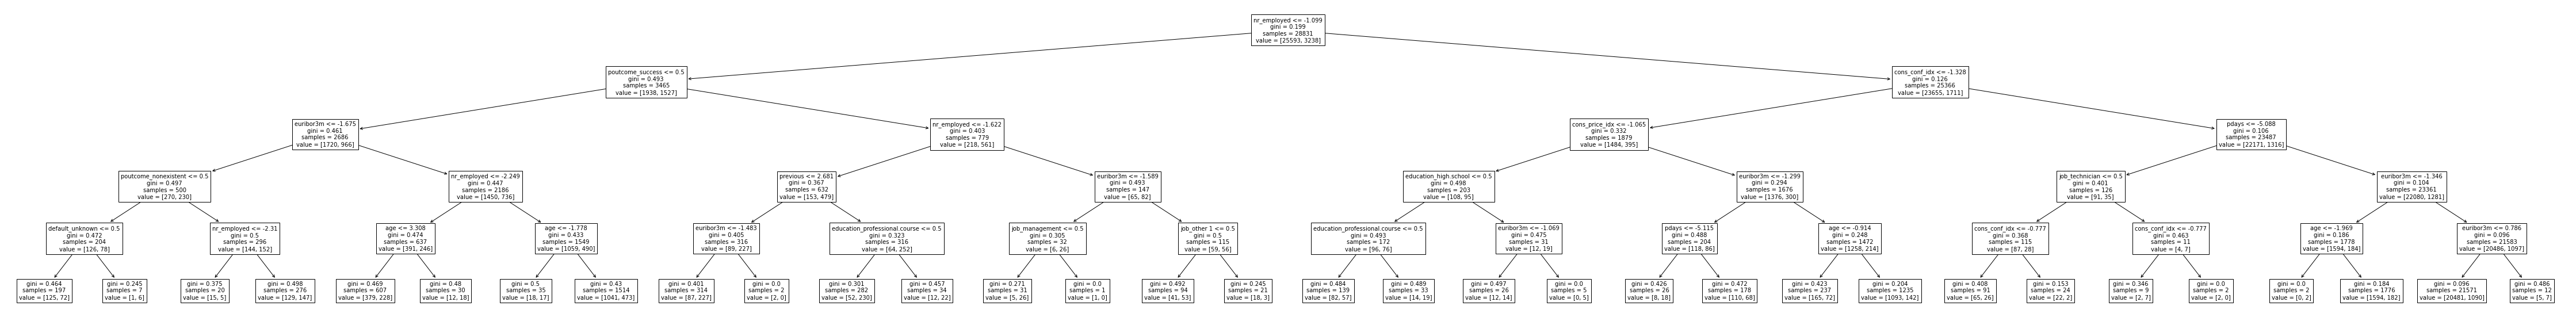

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(80,10))  # set plot size (denoted in inches)
tree.plot_tree(model_30, fontsize=10, feature_names=h3)
plt.show()

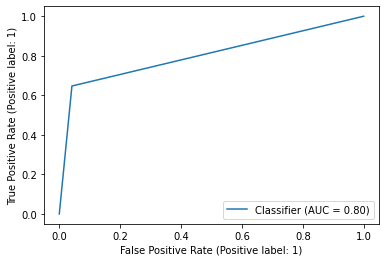

Accuracy=0.937984496124031, Precision=0.944974791015415, Recall=0.937984496124031 for dataset 1 and model 1


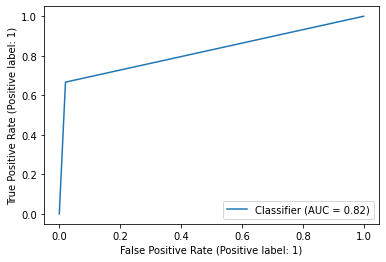

Accuracy=0.9651162790697675, Precision=0.9665437552480742, Recall=0.9651162790697675 for dataset 1 and model 2
Accuracy=0.9184952978056427, Precision=0.917126747338346, Recall=0.9184952978056427 for dataset 2 and model 1
Accuracy=0.8949843260188087, Precision=0.8907143958779324, Recall=0.8949843260188087 for dataset 2 and model 2


In [ ]:
# Nomenclature: model_<datasetNumber><modelNumber>
# without visualisation

model_11 = LogitTree(min_leaf_samples=10, max_depth=5)
a11,p11,r11 = run_model(model_11, X1, y1, h1)
print(f"Accuracy={a11}, Precision={p11}, Recall={r11} for dataset 1 and model 1")

model_12 = LogitTree(min_leaf_samples=2, num_split_attributes=2)
a12,p12,r12 = run_model(model_12, X1, y1, h1)
print(f"Accuracy={a12}, Precision={p12}, Recall={r12} for dataset 1 and model 2")

model_21 = LogitTree(min_leaf_samples=10, max_depth=5)
a21,p21,r21 = run_model(model_21, X2, y2, h2)
print(f"Accuracy={a21}, Precision={p21}, Recall={r21} for dataset 2 and model 1")

model_22 = LogitTree(min_leaf_samples=2, num_split_attributes=2)
a22,p22,r22 = run_model(model_22, X2, y2, h2)
print(f"Accuracy={a22}, Precision={p22}, Recall={r22} for dataset 2 and model 2")

model_31 = LogitTree(min_leaf_samples=10, max_depth=5)
a31,p31,r31 = run_model(model_31, X3, y3, h3)
print(f"Accuracy={a31}, Precision={p31}, Recall={r31} for dataset 3 and model 1")

model_32 = LogitTree(min_leaf_samples=2, num_split_attributes=2)
a32,p32,r32 = run_model(model_32, X3, y3, h3)
print(f"Accuracy={a32}, Precision={p32}, Recall={r32} for dataset 3 and model 2")


# Recurse trees 

In [ ]:
model_11.recurse_tree(h1)

Internal node with index: 0, attribute: Schiller, threshold: 0.0, loss: 10000000, at depth: 0
Left child of 0: Internal node with index: 1, attribute: Age, threshold: 39.0, loss: 10000000, at depth: 1
Left child of 1: Leaf node with index: 3, attribute: Age, threshold: [], loss: 10000000, at depth: 2
Right child of 1: Leaf node with index: 4, attribute: Age, threshold: [], loss: 10000000, at depth: 2
Right child of 0: Leaf node with index: 2, attribute: STDs:syphilis, threshold: [], loss: 10000000, at depth: 1


In [ ]:
model_12.recurse_tree(h1)

Internal node with index: 0, attribute: ['STDs:syphilis', 'Schiller'], threshold: [0.0, 0.0], loss: 10000000, at depth: 0
Left child of 0: Internal node with index: 1, attribute: ['Age', 'Number of sexual partners'], threshold: [21.0, 3.0], loss: 10000000, at depth: 1
Left child of 1: Internal node with index: 3, attribute: ['Age', 'Number of sexual partners'], threshold: [20.0, 3.0], loss: 10000000, at depth: 2
Left child of 3: Internal node with index: 7, attribute: ['Age', 'Number of sexual partners'], threshold: [19.0, 2.0], loss: 10000000, at depth: 3
Left child of 7: Leaf node with index: 15, attribute: ['Age', 'Number of sexual partners'], threshold: [], loss: 10000000, at depth: 4
Right child of 7: Internal node with index: 16, attribute: ['Age', 'Number of sexual partners'], threshold: [20.0, 1.0], loss: 10000000, at depth: 4
Left child of 16: Leaf node with index: 33, attribute: [], threshold: [], loss: 10000000, at depth: 5
Right child of 16: Leaf node with index: 34, attrib

In [ ]:
model_21.recurse_tree(h2)

Internal node with index: 0, attribute: percentage_of_time_with_abnormal_long_term_variability, threshold: 0.2747252747252747, loss: 10000000, at depth: 0
Left child of 0: Internal node with index: 1, attribute: histogram_mode, threshold: 0.5196850393700787, loss: 10000000, at depth: 1
Left child of 1: Internal node with index: 3, attribute: histogram_mean, threshold: 0.3027522935779817, loss: 10000000, at depth: 2
Left child of 3: Internal node with index: 7, attribute: baseline value, threshold: 0.4444444444444446, loss: 10000000, at depth: 3
Left child of 7: Internal node with index: 15, attribute: baseline value, threshold: 0.2777777777777777, loss: 10000000, at depth: 4
Left child of 15: Leaf node with index: 31, attribute: [], threshold: [], loss: 10000000, at depth: 5
Right child of 15: Leaf node with index: 32, attribute: [], threshold: [], loss: 10000000, at depth: 5
Right child of 7: Leaf node with index: 16, attribute: baseline value, threshold: [], loss: 10000000, at depth:

In [ ]:
model_22.recurse_tree(h2)

Internal node with index: 0, attribute: ['abnormal_short_term_variability', 'histogram_mean'], threshold: [0.8666666666666668, 1.0000000000000002], loss: 10000000, at depth: 0
Left child of 0: Internal node with index: 1, attribute: ['percentage_of_time_with_abnormal_long_term_variability', 'prolongued_decelerations_0.002'], threshold: [0.7692307692307693, 1.0], loss: 10000000, at depth: 1
Left child of 1: Internal node with index: 3, attribute: ['histogram_median', 'prolongued_decelerations_0.0'], threshold: [0.724770642201835, 1.0], loss: 10000000, at depth: 2
Left child of 3: Internal node with index: 7, attribute: ['histogram_median', 'prolongued_decelerations_0.0'], threshold: [0.3486238532110093, 1.0], loss: 10000000, at depth: 3
Left child of 7: Internal node with index: 15, attribute: ['histogram_mean', 'histogram_variance'], threshold: [0.3394495412844038, 0.1338289962825278], loss: 10000000, at depth: 4
Left child of 15: Leaf node with index: 31, attribute: [], threshold: [],

In [ ]:
model_31.recurse_tree(h3)

Internal node with index: 0, attribute: pdays, threshold: -5.010338004512505, loss: 10000000, at depth: 0
Left child of 0: Internal node with index: 1, attribute: nr_employed, threshold: -2.0696825532812366, loss: 10000000, at depth: 1
Left child of 1: Internal node with index: 3, attribute: cons_price_idx, threshold: 0.2994570543097979, loss: 10000000, at depth: 2
Left child of 3: Internal node with index: 7, attribute: cons_price_idx, threshold: -0.3570362442528725, loss: 10000000, at depth: 3
Left child of 7: Internal node with index: 15, attribute: cons_price_idx, threshold: -1.9775381233365408, loss: 10000000, at depth: 4
Left child of 15: Leaf node with index: 31, attribute: [], threshold: [], loss: 10000000, at depth: 5
Right child of 15: Leaf node with index: 32, attribute: [], threshold: [], loss: 10000000, at depth: 5
Right child of 7: Leaf node with index: 16, attribute: cons_price_idx, threshold: [], loss: 10000000, at depth: 4
Right child of 3: Internal node with index: 8,

In [ ]:
model_32.recurse_tree(h3)

Internal node with index: 0, attribute: ['pdays', 'nr_employed'], threshold: [0.1954139001271294, -2.8156965971113914], loss: 10000000, at depth: 0
Left child of 0: Internal node with index: 1, attribute: ['cons_price_idx', 'poutcome_success'], threshold: [2.0581680488803427, 0.0], loss: 10000000, at depth: 1
Left child of 1: Internal node with index: 3, attribute: ['previous', 'education_professional.course'], threshold: [-0.3494942841975746, 0.0], loss: 10000000, at depth: 2
Left child of 3: Internal node with index: 7, attribute: ['age', 'job_technician'], threshold: [-0.8659393039847795, 0.0], loss: 10000000, at depth: 3
Left child of 7: Internal node with index: 15, attribute: ['job_blue-collar', 'housing_yes'], threshold: [0.0, 0.0], loss: 10000000, at depth: 4
Left child of 15: Leaf node with index: 31, attribute: [], threshold: [], loss: 10000000, at depth: 5
Right child of 15: Leaf node with index: 32, attribute: [], threshold: [], loss: 10000000, at depth: 5
Right child of 7:

In [ ]:
from sklearn.metrics import confusion_matrix

_, X_test, _, y_test = train_test_split(X1, y1, test_size=0.3, shuffle=True)
print("Confusion matrix for model 1 on dataset 1","\n", confusion_matrix(y_test, model_11.list_predict(X_test)))
print("Confusion matrix for model 2 on dataset 1","\n", confusion_matrix(y_test, model_12.list_predict(X_test)))

_, X_test, _, y_test = train_test_split(X2, y2, test_size=0.3, shuffle=True)
print("Confusion matrix for model 1 on dataset 2","\n", confusion_matrix(y_test, model_21.list_predict(X_test)))
print("Confusion matrix for model 2 on dataset 2","\n", confusion_matrix(y_test, model_22.list_predict(X_test)))

_, X_test, _, y_test = train_test_split(X3, y3, test_size=0.3, shuffle=True)
print("Confusion matrix for model 1 on dataset 3","\n", confusion_matrix(y_test, model_31.list_predict(X_test)))
print("Confusion matrix for model 2 on dataset 3","\n", confusion_matrix(y_test, model_32.list_predict(X_test)))

Confusion matrix for model 1 on dataset 1 
 [[205   6]
 [  2  13]]
Confusion matrix for model 2 on dataset 1 
 [[208   3]
 [  3  12]]
Confusion matrix for model 1 on dataset 2 
 [[480   6   2]
 [ 34  57   1]
 [  4  13  41]]
Confusion matrix for model 2 on dataset 2 
 [[473  13   2]
 [ 28  62   2]
 [  0   7  51]]
Confusion matrix for model 1 on dataset 3 
 [[10843   143]
 [ 1019   352]]
Confusion matrix for model 2 on dataset 3 
 [[10847   139]
 [ 1000   371]]


#Statistical Tests

In [ ]:
from mlxtend.evaluate import mcnemar
from mlxtend.evaluate import mcnemar_table
from mlxtend.evaluate import paired_ttest_5x2cv
from mlxtend.evaluate import proportion_difference
from mlxtend.evaluate import paired_ttest_kfold_cv
from mlxtend.evaluate import paired_ttest_resampled
from scipy.stats import t as t_dist

In [ ]:
# Wisconsin Signed Test.
import scipy.stats as stats
p = stats.wilcoxon([a11,a21,a31], [a21,a22,a32])

In [ ]:
print(p)

WilcoxonResult(statistic=0.0, pvalue=0.25)


In [ ]:
# Proportions Z-Test
z, p = proportion_difference(a11, a12, n_1=0.3*(len(y1)))
print(f" Proportions Z-Test z statistic: {z}, p-value: {p}\n")

z, p = proportion_difference(a21, a22, n_1=0.3*(len(y2)))
print(f" Proportions Z-Test z statistic: {z}, p-value: {p}\n")

z, p = proportion_difference(a31, a32, n_1=0.3*(len(y3)))
print(f" Proportions Z-Test z statistic: {z}, p-value: {p}\n")

 Proportions Z-Test z statistic: 1.5151191043234233, p-value: 0.9351288777783295

 Proportions Z-Test z statistic: 0.5478657417173515, p-value: 0.7081079532510551

 Proportions Z-Test z statistic: 0.10439027873045763, p-value: 0.541570181508626



In [ ]:
def paired_t_test(p):
    p_hat = np.mean(p)
    n = len(p)
    den = np.sqrt(sum([(diff - p_hat)**2 for diff in p]) / (n - 1))
    t = (p_hat * (n**(1/2))) / den
    
    p_value = t_dist.sf(t, n-1)*2
    
    return t, p_value

n_tests = 5

p_ = []
rng = np.random.RandomState(42)
for i in range(n_tests):

    print(f"Round {i+1}")
    randint = rng.randint(low=0, high=32767)
    X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.20, random_state=randint)
    
    model_1 = LogitTree(min_leaf_samples=10, max_depth=5)
    model_2 = LogitTree(min_leaf_samples=2, num_split_attributes=2)

    model_1.fit(X_train, y_train)
    model_2.fit(X_train, y_train)

    y_pred_1 = model_1.list_predict(X_test) 
    y_pred_2 = model_2.list_predict(X_test)
    
    acc1 = accuracy_score(y_test, y_pred_1)
    acc2 = accuracy_score(y_test, y_pred_2)
    p_.append(acc1 - acc2)
    
print("Paired t-test Resampled")
t, p = paired_t_test(p_)
print(f"t statistic: {t}, p-value: {p}\n")

Round 1
Round 2
Round 3
Round 4
Round 5
Paired t-test Resampled
t statistic: 0.3885143449429059, p-value: 0.717428359914488



In [ ]:
p_ = []

from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
i=0
for train_index, test_index in kf.split(X1):
    
    print(f"iteration {i}")
    i+=1
    X_train, X_test, y_train, y_test = X1[train_index], X1[test_index], y1[train_index], y1[test_index]
    
    model_1 = LogitTree(min_leaf_samples=10, max_depth=5)
    model_2 = LogitTree(min_leaf_samples=2, num_split_attributes=2)

    model_1.fit(X_train, y_train)
    model_2.fit(X_train, y_train)
    
    y_pred_1 = model_1.list_predict(X_test)
    y_pred_2 = model_2.list_predict(X_test)

    acc1 = accuracy_score(y_test, y_pred_1)
    acc2 = accuracy_score(y_test, y_pred_2)
    p_.append(acc1 - acc2)

print("Cross Validated Paired t-test")
t, p = paired_t_test(p_)
print(f"t statistic: {t}, p-value: {p}\n")

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
Cross Validated Paired t-test
t statistic: 0.0012708973635689395, p-value: 0.9990468272980619



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=randint)
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)

y_pred_1 = model_1.list_predict(X_test) 
y_pred_2 = model_2.list_predict(X_test)

print("McNemar's test")
table = mcnemar_table(y_target=y_test, y_model1=np.array(y_pred_1), y_model2=np.array(y_pred_2))
chi2_, p = mcnemar(ary=table, corrected=True)
print(f"chi² statistic: {chi2_}, p-value: {p}\n")

McNemar's test
chi² statistic: 1.4545454545454546, p-value: 0.22779999398822554



In [ ]:
def five_two_statistic(p1, p2):
    p1 = np.array(p1)
    p2 = np.array(p2)
    p_hat = (p1 + p2) / 2
    s = (p1 - p_hat)**2 + (p2 - p_hat)**2
    t = p1[0] / np.sqrt(1/5. * sum(s))
    
    p_value = t_dist.sf(t, 5)*2
    
    return t, p_value

p_1 = []
p_2 = []

rng = np.random.RandomState(42)
for i in range(5):
    randint = rng.randint(low=0, high=32767)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=randint)

    model_1.fit(X_train, y_train)
    model_2.fit(X_train, y_train)
    
    y_pred_1 = model_1.list_predict(X_test) 
    y_pred_2 = model_2.list_predict(X_test)

    acc1 = accuracy_score(y_test, y_pred_1)
    acc2 = accuracy_score(y_test, y_pred_2)
    p_1.append(acc1 - acc2)

    model_1.fit(X_test, y_test)
    model_2.fit(X_test, y_test)
    
    y_pred_1 = model_1.list_predict(X_test)
    y_pred_2 = model_2.list_predict(X_test)

    acc1 = accuracy_score(y_test, y_pred_1)
    acc2 = accuracy_score(y_test, y_pred_2)
    p_2.append(acc1 - acc2)

# Running the test
print("5x2 CV Paired t-test")     
t, p = five_two_statistic(p_1, p_2)
print(f"t statistic: {t}, p-value: {p}\n")

5x2 CV Paired t-test
t statistic: 0.0, p-value: 1.0



# Cross Validation

In [ ]:
from sklearn.model_selection import KFold
from numpy import mean

def cross_validate(model, X, y):
  accuracy_scores = []
  precision_scores = []
  recall_scores = []
  f1_scores = []
  kf = KFold(n_splits=5, shuffle=True, random_state=42)

  for train_index, test_index in kf.split(X,y):
      X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
      model.fit(X_train, y_train)
      y_pred = model.list_predict(X_test)
      a = accuracy_score(y_test,y_pred)
      p = precision_score(y_test, y_pred, average='macro')
      r = recall_score(y_test, y_pred, average='macro')
      # print(p,r,a)
      
      accuracy_scores.append(a)
      precision_scores.append(p)
      recall_scores.append(r)
      f1_scores.append(p*r/(p+r))   
  
  return mean(accuracy_scores), mean(precision_scores), mean(recall_scores), mean(f1_scores)


In [ ]:
model_1 = LogitTree(min_leaf_samples=10, max_depth=5)
model_2 = LogitTree(min_leaf_samples=2, num_split_attributes=2)

a,p,r,f1 = cross_validate(model_1, X1, y1)
print(f"Dataset 1 model 1 cross validation mean accuracy={a}, precision={p}, recall={r}, f1={f1}")
a,p,r,f1 = cross_validate(model_2, X1, y1)
print(f"Dataset 1 model 2 cross validation mean accuracy={a}, precision={p}, recall={r}, f1={f1}")

Dataset 1 model 1 cross validation mean accuracy=0.942896247240618, precision=0.7967631505491032, recall=0.7878617761868284, f1=0.39508759387184356
Dataset 1 model 2 cross validation mean accuracy=0.9428874172185431, precision=0.7693193266878412, recall=0.7764798150961909, f1=0.3862026193284925


In [ ]:
model_1 = LogitTree(min_leaf_samples=10, max_depth=5)
model_2 = LogitTree(min_leaf_samples=2, num_split_attributes=2)

a,p,r,f1 = cross_validate(model_1, X2, y2)
print(f"Dataset 2 model 1 cross validation mean accuracy={a}, precision={p}, recall={r}, f1={f1}")
a,p,r,f1 = cross_validate(model_2, X2, y2)
print(f"Dataset 2 model 2 cross validation mean accuracy={a}, precision={p}, recall={r}, f1={f1}")

In [ ]:
model_1 = LogitTree(min_leaf_samples=10, max_depth=5)
model_2 = LogitTree(min_leaf_samples=2, num_split_attributes=2)

a,p,r,f1 = cross_validate(model_1, X3, y3)
print(f"Dataset 3 model 1 cross validation mean accuracy={a}, precision={p}, recall={r}, f1={f1}")
a,p,r,f1 = cross_validate(model_2, X3, y3)
print(f"Dataset 3 model 2 cross validation mean accuracy={a}, precision={p}, recall={r}, f1={f1}")

Dataset 3 model 1 cross validation mean accuracy=0.8973730350528732, precision=0.7766697391883491, recall=0.5940005971858753, f1=0.3364543807216242
Dataset 3 model 2 cross validation mean accuracy=0.8970816668362895, precision=0.7666705377685022, recall=0.600057085820769, f1=0.3365914726349441
